# Deepfake Detection - Model Load

1. Load the model from extracted faces csv file.
2. Setup a sample ResNet with pre-trained 'imagenet' weights.
3. Train model
4. Write test function

## Setup and Imports

In [1]:
from platform import python_version

python_version()

'3.8.13'

In [2]:
import tensorflow as tf
from tensorflow import keras

tf.__version__, keras.__version__

('2.8.0', '2.8.0')

In [3]:
import os

# Check GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enables use of the GPU on a Mac using plaidml (ignore otherwise)


Num GPUs Available:  1


In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import random
import sys

from tqdm import tqdm

from typing import List

## Load dataset

In [5]:
DATASET_PATH = "../dataset-sample-faces.csv"

In [6]:
data = pd.read_csv(DATASET_PATH)

data.head()

,image_filename,image_fullpath,face_confidence,label,video_filename,video_fullpath,video_dataset
0,id0_0000_1.png,../extracted_faces/id0_0000/id0_0000_1.png,0.997610,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
1,id0_0000_15.png,../extracted_faces/id0_0000/id0_0000_15.png,0.996413,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
2,id0_0000_29.png,../extracted_faces/id0_0000/id0_0000_29.png,0.999750,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
3,id0_0000_43.png,../extracted_faces/id0_0000/id0_0000_43.png,0.995511,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
4,id0_0000_57.png,../extracted_faces/id0_0000/id0_0000_57.png,0.997212,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2


In [7]:
list(data.columns)

['image_filename',
 'image_fullpath',
 'face_confidence',
 'label',
 'video_filename',
 'video_fullpath',
 'video_dataset']

In [8]:
data['label'].value_counts()

REAL    48200
FAKE    46832
Name: label, dtype: int64

In [9]:
data = data.sample(n=20000, random_state=42)

In [10]:
data['label'].value_counts()

REAL    10060
FAKE     9940
Name: label, dtype: int64

Although, there is a slight imbalance in the dataset as seen above, we sampled the number of "FAKE" videos equal to the number of "REAL" videos in the notebook [Deepfake Detection - Dataset Preparation.ipynb](./Deepfake%20Detection%20-%20Dataset%20Preparation.ipynb)

## Data Splitting

To ensure that images from a video in the train dataset is not in the validation/test dataset, a custom split function was made.

In [11]:
def split_dataframe(data, test_size, column, shuffle=False, random_state=1):
  """Splits the dataframe based on unique values in a given 
  column."""
  # Gets a list of unique videos 
  videos = list(data[column].unique())
  n = len(videos)
  k = int(0.2 * n)

  if shuffle:
    data = data.sample(frac=1)

  # Sets the random state
  random.seed(random_state)
  split_videos = random.sample(videos, k)

  df1 = data[data[column].isin(split_videos)]
  df2 = data[~data[column].isin(split_videos)]
  
  assert(len(df1[df1.isin(df2)].dropna()) == 0)
  
  df1.sort_index(inplace=True)
  df2.sort_index(inplace=True)
  
  return df2, df1

In [12]:
TRAIN_SPLIT = 0.2
VAL_SPLIT = 0.25

train_df, test_df = split_dataframe(data=data, 
                                    test_size=TRAIN_SPLIT,
                                    column="video_filename",
                                    shuffle=True,
                                    random_state=42)

train_df, val_df = split_dataframe(data=data, 
                                  test_size=VAL_SPLIT,
                                  column="video_filename",
                                  random_state=42)

/var/folders/hp/zn9_yg9d1tz9_w596brfcm580000gn/T/ipykernel_5386/1251354954.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.sort_index(inplace=True)
/var/folders/hp/zn9_yg9d1tz9_w596brfcm580000gn/T/ipykernel_5386/1251354954.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_index(inplace=True)
/var/folders/hp/zn9_yg9d1tz9_w596brfcm580000gn/T/ipykernel_5386/1251354954.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [13]:
train_df['label'].value_counts()

FAKE    8058
REAL    7942
Name: label, dtype: int64

In [14]:
test_df['label'].value_counts()

REAL    2118
FAKE    1882
Name: label, dtype: int64

In [15]:
val_df['label'].value_counts()

REAL    2118
FAKE    1882
Name: label, dtype: int64

## Data Augmentation 

**Gaussian Noise:**

**Random Erasing:** https://arxiv.org/abs/1708.04896
    - Source code: https://github.com/zhunzhong07/Random-Erasing

In [16]:
import math
import random
from keras.preprocessing.image import ImageDataGenerator

def gaussian_noise(image, probability):
  if random.uniform(0,1) > probability:
    return image
  row,col,ch= image.shape
  mean = 0
  var = 0.01 # slightly reduced
  sigma = var ** 0.5
  gauss = np.random.normal(mean,sigma,(row,col))
  noisy = image
  for i in range(ch):
    noisy[:,:,i] = image[:,:,i] + gauss
  return noisy


def random_erasing(img, probability):
  """
  Performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.

  probability: The probability that the operation will be performed.
  sl: min erasing area
  sh: max erasing area
  r1: min aspect ratio
  mean: erasing value

  Note: Code modified for img.shape parameters instead of img.size()
  """
  # Source: https://github.com/zhunzhong07/Random-Erasing
  if random.uniform(0,1) > probability:
    return img

  # Default params
  mean = [0.4914, 0.4822, 0.4465]
  sl = 0.02
  sh = 0.4
  r1 = 0.3

  for attempt in range(100):
    area = img.shape[0] * img.shape[1]

    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    h = int(round(math.sqrt(target_area * aspect_ratio)))
    w = int(round(math.sqrt(target_area / aspect_ratio)))

    if w < img.shape[0] and h < img.shape[1]:
        x1 = random.randint(0, img.shape[1] - h)
        y1 = random.randint(0, img.shape[0] - w)
        if img.shape[2] == 3:
            img[x1:x1+h, y1:y1+w, 0] = mean[0]
            img[x1:x1+h, y1:y1+w, 1] = mean[1]
            img[x1:x1+h, y1:y1+w, 2] = mean[2]
        else:
            img[0, x1:x1+h, y1:y1+w] = mean[0]

        return img
  return img

class CustomDataGenerator(ImageDataGenerator):
  '''
  Custom image data generator.
  Allows image compression and random erasing.
  '''
  def __init__(self, 
               gaussian_noise : float = 0., 
               random_erasing : float = 0.,
               **kwargs):
    super().__init__(preprocessing_function=self.custom_augmentations,
                    **kwargs)
    self.gaussian_noise = gaussian_noise
    self.random_erasing = random_erasing
  
  def custom_augmentations(self, image):
    image = gaussian_noise(image, self.gaussian_noise)
    image = random_erasing(image, self.random_erasing)
    return image

In [17]:
train_datagen = CustomDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  rotation_range=0.1,
                                  horizontal_flip=True,
                                  # Custom augmentation probabilities
                                  gaussian_noise=0.1,
                                  random_erasing=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe = train_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = 64,
  seed = 42,
  class_mode = "binary",
  target_size=(128, 128)
)

valid_generator = train_datagen.flow_from_dataframe(
  dataframe = val_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = 64,
  seed = 42,
  class_mode = "binary",
  target_size=(128, 128)
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe = test_df, 
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size=64,
  seed = 42,
  shuffle=False,
  class_mode="binary",
  target_size=(128, 128)
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


## Resnet Model

In [30]:
class EfficientNet:
    def __init__(self, input_size, n_freeze=143):
        self.input_size = input_size
        self.n_freeze = n_freeze
        self.model = self._initialise_model()
        self.history = None
    
    def _initialise_model(self):
        input_t = keras.Input(shape=self.input_size)
        base_model = keras.applications.EfficientNetB7(
            include_top=False,
            weights="imagenet",
            input_tensor=input_t,
        #     input_shape=None,
        #     pooling=None,
#             classes=1,
#             classifier_activation="sigmoid"
        )
        model = keras.models.Sequential()
        model.add(base_model)
        model.add(keras.layers.GlobalAveragePooling2D())
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        return model
    
    def train_model(self, train_generator, valid_generator,
                   epochs, learning_rate=0.0001,
                   save_model:str=None,
                   verbose=1):
        train_steps = len(train_generator)
        val_steps = len(valid_generator)
      
        self.model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
            metrics=['accuracy']
        )
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=val_steps,
            verbose=verbose,
        )
        
        if save_model is not None:
          self.save_model(save_model)
        return self.history.history

    def save_model(self,filepath):
        self.model.save(filepath)

    def get_history(self):
        return self.history.history

In [31]:
model = EfficientNet(input_size=(128,128,3), n_freeze=143)

In [ ]:
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=10,
                            learning_rate=0.0001,
                            save_model="../weights/efficientnetb7-v1.h5")

Epoch 1/10


2022-05-31 10:40:22.954113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [45]:
history = model.get_history()

In [48]:
pickle_path = "pickle/resnet50-1.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)
  
with open(pickle_path, "rb") as f:
  history = pickle.load(f)

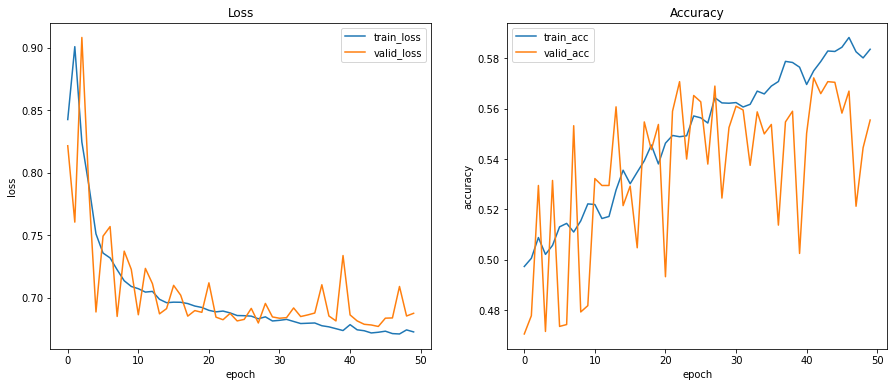

In [47]:
def plot_loss_and_accuracy(history, figsize=(15,6)):
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].plot(history['loss'], label='train_loss')
  ax[0].plot(history['val_loss'], label='valid_loss')
  ax[0].set_title("Loss")
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("loss")
  ax[0].legend()
  ax[1].plot(history['accuracy'], label='train_acc')
  ax[1].plot(history['val_accuracy'], label='valid_acc')
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  plt.show()
  
  
plot_loss_and_accuracy(history)